In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix

In [7]:
# Load data

df = pd.read_csv('Surgical-deepnet.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14635 entries, 0 to 14634
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bmi                  14635 non-null  float64
 1   Age                  14635 non-null  float64
 2   asa_status           14635 non-null  int64  
 3   baseline_cancer      14635 non-null  int64  
 4   baseline_charlson    14635 non-null  int64  
 5   baseline_cvd         14635 non-null  int64  
 6   baseline_dementia    14635 non-null  int64  
 7   baseline_diabetes    14635 non-null  int64  
 8   baseline_digestive   14635 non-null  int64  
 9   baseline_osteoart    14635 non-null  int64  
 10  baseline_psych       14635 non-null  int64  
 11  baseline_pulmonary   14635 non-null  int64  
 12  ahrq_ccs             14635 non-null  int64  
 13  ccsComplicationRate  14635 non-null  float64
 14  ccsMort30Rate        14635 non-null  float64
 15  complication_rsi     14635 non-null 

In [8]:
# Shuffle the data

df = df.sample(frac=1, random_state=15).reset_index(drop=True)


# Generate indices for splits

test_ind = round(len(df)*0.25)
train_ind = test_ind + round(len(df)*0.01)
unlabeled_ind = train_ind + round(len(df)*0.74)


# Partition the data

test = df.iloc[:test_ind]
train = df.iloc[test_ind:train_ind]
unlabeled = df.iloc[train_ind:unlabeled_ind]


# Assign data to train, test, and unlabeled sets

X_train = train.drop('complication', axis=1)
y_train = train.complication

X_unlabeled = unlabeled.drop('complication', axis=1)

X_test = test.drop('complication', axis=1)
y_test = test.complication


# Check dimensions of data after splitting

print(f"X_train dimensions: {X_train.shape}")
print(f"y_train dimensions: {y_train.shape}\n")

print(f"X_test dimensions: {X_test.shape}")
print(f"y_test dimensions: {y_test.shape}\n")

print(f"X_unlabeled dimensions: {X_unlabeled.shape}")

X_train dimensions: (146, 24)
y_train dimensions: (146,)

X_test dimensions: (3659, 24)
y_test dimensions: (3659,)

X_unlabeled dimensions: (10830, 24)


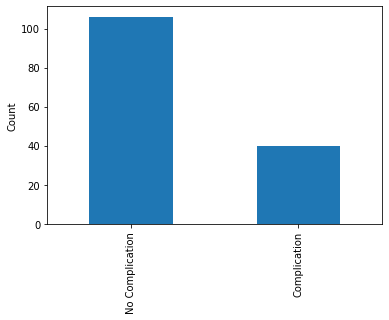

In [9]:
# Visualize class distribution

y_train.value_counts().plot(kind='bar')
plt.xticks([0,1], ['No Complication', 'Complication'])
plt.ylabel('Count');

Train f1 Score: 0.5846153846153846
Test f1 Score: 0.500873616773442


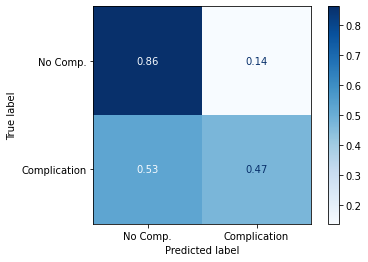

In [10]:
# Logistic Regression Classifier

clf = LogisticRegression(max_iter=1000)

clf.fit(X_train, y_train)
y_hat_test = clf.predict(X_test)
y_hat_train = clf.predict(X_train)

train_f1 = f1_score(y_train, y_hat_train)
test_f1 = f1_score(y_test, y_hat_test)

print(f"Train f1 Score: {train_f1}")
print(f"Test f1 Score: {test_f1}")

plot_confusion_matrix(clf, X_test, y_test, cmap='Blues', normalize='true',
                     display_labels=['No Comp.', 'Complication']);

In [11]:
# Generate probabilities for each prediction

clf.predict_proba(X_test)

array([[0.93928352, 0.06071648],
       [0.23315246, 0.76684754],
       [0.93928352, 0.06071648],
       ...,
       [0.62006237, 0.37993763],
       [0.41253146, 0.58746854],
       [0.24330359, 0.75669641]])

In [12]:
# Initiate iteration counter
iterations = 0

# Containers to hold f1_scores and # of pseudo-labels
train_f1s = []
test_f1s = []
pseudo_labels = []

# Assign value to initiate while loop
high_prob = [1] 

# Loop will run until there are no more high-probability pseudo-labels
while len(high_prob) > 0:
        
    # Fit classifier and make train/test predictions
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)
    y_hat_train = clf.predict(X_train)
    y_hat_test = clf.predict(X_test)

    # Calculate and print iteration # and f1 scores, and store f1 scores
    train_f1 = f1_score(y_train, y_hat_train)
    test_f1 = f1_score(y_test, y_hat_test)
    print(f"Iteration {iterations}")
    print(f"Train f1: {train_f1}")
    print(f"Test f1: {test_f1}")
    train_f1s.append(train_f1)
    test_f1s.append(test_f1)
   
    # Generate predictions and probabilities for unlabeled data
    print(f"Now predicting labels for unlabeled data...")

    pred_probs = clf.predict_proba(X_unlabeled)
    preds = clf.predict(X_unlabeled)
    prob_0 = pred_probs[:,0]
    prob_1 = pred_probs[:,1]

    # Store predictions and probabilities in dataframe
    df_pred_prob = pd.DataFrame([])
    df_pred_prob['preds'] = preds
    df_pred_prob['prob_0'] = prob_0
    df_pred_prob['prob_1'] = prob_1
    df_pred_prob.index = X_unlabeled.index
    
    # Separate predictions with > 99% probability
    high_prob = pd.concat([df_pred_prob.loc[df_pred_prob['prob_0'] > 0.99],
                           df_pred_prob.loc[df_pred_prob['prob_1'] > 0.99]],
                          axis=0)
    
    print(f"{len(high_prob)} high-probability predictions added to training data.")
    
    pseudo_labels.append(len(high_prob))

    # Add pseudo-labeled data to training data
    X_train = pd.concat([X_train, X_unlabeled.loc[high_prob.index]], axis=0)
    y_train = pd.concat([y_train, high_prob.preds])      
    
    print(X_train.shape)
    print(y_train.shape)
    # Drop pseudo-labeled instances from unlabeled data
    X_unlabeled = X_unlabeled.drop(index=high_prob.index)
    print(f"{len(X_unlabeled)} unlabeled instances remaining.\n")
    
    # Update iteration counter
    iterations += 1

Iteration 0
Train f1: 0.5846153846153846
Test f1: 0.500873616773442
Now predicting labels for unlabeled data...
42 high-probability predictions added to training data.
(188, 24)
(188,)
10788 unlabeled instances remaining.

Iteration 1
Train f1: 0.7627118644067796
Test f1: 0.5037463976945246
Now predicting labels for unlabeled data...
30 high-probability predictions added to training data.
(218, 24)
(218,)
10758 unlabeled instances remaining.

Iteration 2
Train f1: 0.8181818181818182
Test f1: 0.5059965733866362
Now predicting labels for unlabeled data...
20 high-probability predictions added to training data.
(238, 24)
(238,)
10738 unlabeled instances remaining.

Iteration 3
Train f1: 0.8457142857142856
Test f1: 0.5088218554354014
Now predicting labels for unlabeled data...
22 high-probability predictions added to training data.
(260, 24)
(260,)
10716 unlabeled instances remaining.

Iteration 4
Train f1: 0.8601036269430052
Test f1: 0.5093590470788429
Now predicting labels for unlabeled 

Iteration 37
Train f1: 0.9471766848816029
Test f1: 0.5267134376686454
Now predicting labels for unlabeled data...
5 high-probability predictions added to training data.
(886, 24)
(886,)
10090 unlabeled instances remaining.

Iteration 38
Train f1: 0.9473684210526315
Test f1: 0.5262020529443544
Now predicting labels for unlabeled data...
3 high-probability predictions added to training data.
(889, 24)
(889,)
10087 unlabeled instances remaining.

Iteration 39
Train f1: 0.9475587703435805
Test f1: 0.5262020529443544
Now predicting labels for unlabeled data...
2 high-probability predictions added to training data.
(891, 24)
(891,)
10085 unlabeled instances remaining.

Iteration 40
Train f1: 0.9475587703435805
Test f1: 0.5259179265658748
Now predicting labels for unlabeled data...
1 high-probability predictions added to training data.
(892, 24)
(892,)
10084 unlabeled instances remaining.

Iteration 41
Train f1: 0.9475587703435805
Test f1: 0.5262020529443544
Now predicting labels for unlabele

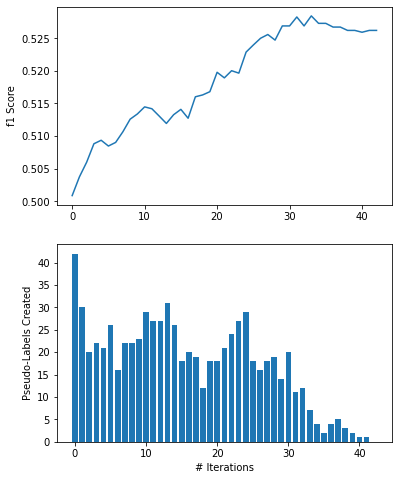

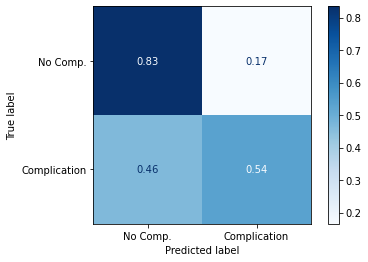

In [9]:
# Plot f1 scores and number of pseudo-labels added for all iterations

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6,8))
ax1.plot(range(iterations), test_f1s)
ax1.set_ylabel('f1 Score')
ax2.bar(x=range(iterations), height=pseudo_labels)
ax2.set_ylabel('Pseudo-Labels Created')
ax2.set_xlabel('# Iterations');

# View confusion matrix after self-training

plot_confusion_matrix(clf, X_test, y_test, cmap='Blues', normalize='true',
                     display_labels=['No Comp.', 'Complication']);